# Quora Quesiton Pairs

[Competition Homepage](https://www.kaggle.com/c/quora-question-pairs)

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

For each ID in the test set, Kagglers must predict the probability that the questions are duplicates (a number between 0 and 1).  Submissions are evaluated on the log loss between the predicted values and the ground truth.

## IMPORTS

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [72]:
import numpy as np
import pandas as pd
import multiprocessing as mp
import datetime as dt
import math
import os
import gc
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from imblearn.over_sampling import SMOTE

import xgboost as xgb

import gensim.models.doc2vec as d2v

from random import shuffle

from scipy.spatial.distance import cosine

In [4]:
gc.collect()

176

## EDA

### Raw Data Analysis

In [5]:
for f in os.listdir('./data.gi'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('./data.gi/' + f) / 1000000, 2)) + ' MB')

sample_submission.csv         22.35 MB
test.csv                      314.02 MB
train.csv                     63.4 MB


The competition provides 3 .csv files - training set, testing set, and sample submission.  It is interesting to note that the testing set is approximately 5x the size of the training set.  The [Data](https://www.kaggle.com/c/quora-question-pairs/data) section of the competition homepage states the following: 

*"As an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora."*

The sample submission file can be ignored as it is just an example for Kagglers to follow when preparing their .csv files for submission.

### Training Set Analysis

**Train Columns:**
- **id:** (int) question pair identifier
- **qid1:** (int) single question identifer (first in pair)
- **qid2:** (int) single question identfier (second in pair)
- **question1:** (string) first question text
- **question2:** (string) second question text
- **is_duplicate:** (int) binary duplicate indicator - this is our label for supervised training

In [6]:
TRAIN = pd.read_csv('./data.gi/train.csv')
TRAIN.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
TRAIN.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


The last value in the *id* column matches the last row index value, indicating there are no jumps in ID.  The individual question IDs, however, do not appear to increase consistently.  Otherwise, we would expect *qid2* in row 404289 to be 808578.  Therefore, we will need to determine if the same questions are being used across pairs.

#### Duplicate Questions Across Pairs

Number of total questions:    537933
Number of unique questions:   426153
Number of repeated questions: 111780

Percent unique: 0.79%


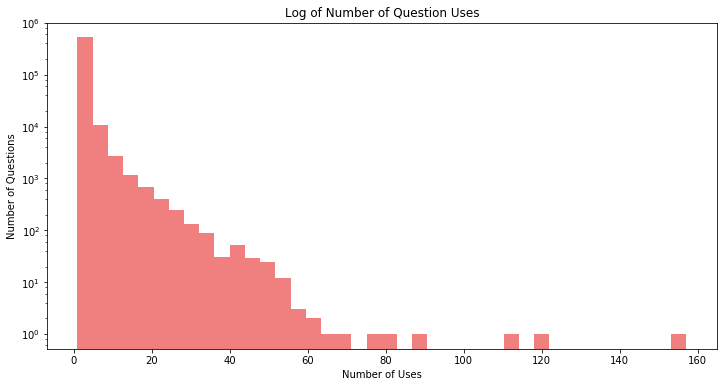

In [8]:
qid = TRAIN.qid1.tolist() + TRAIN.qid2.tolist()
qid_dict = dict.fromkeys(qid, 0)

for x in qid:
    qid_dict[x] += 1

unique = 0
for x in qid_dict:
    if qid_dict[x] == 1:
        unique += 1

total = len(qid_dict)
non_unique = total - unique

print('Number of total questions: '.ljust(30) + str(total))
print('Number of unique questions: '.ljust(30) + str(unique))
print('Number of repeated questions: '.ljust(30) + str(non_unique))
print('\nPercent unique: ' + '{0:.2f}%'.format(unique / total))

plt.figure(figsize=(12, 6))
plt.hist(pd.Series(qid).value_counts(), bins=40, log=True, color='lightcoral', label='train')
plt.xlabel('Number of Uses')
plt.ylabel('Number of Questions')
plt.title('Log of Number of Question Uses')
plt.show()

del qid, qid_dict, unique, total, non_unique

About 80% of questions are used only once, however, there are a number of quetions that are used many times.  There are also a few cases of outliers that are used 100+ times.

#### Class Imbalance of Pairs Labeled as Duplicate

Number of question pairs:     404290
Number of duplicates:         149263
Number of non-duplicates:     255027


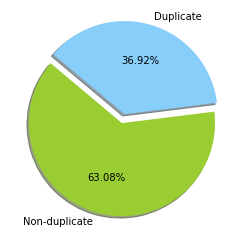

In [9]:
print('Number of question pairs: '.ljust(30) + str(len(TRAIN)))
print('Number of duplicates: '.ljust(30) + str(len(TRAIN[TRAIN.is_duplicate == 1])))
print('Number of non-duplicates: '.ljust(30) + str(len(TRAIN[TRAIN.is_duplicate == 0])))

plt.figure(figsize=(4, 4))
plt.pie(TRAIN.is_duplicate.value_counts(), explode=(0.1, 0), labels=('Non-duplicate', 'Duplicate'), colors=('yellowgreen', 'lightskyblue'), autopct='%1.2f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

There is about a 2:1 class imbalance in favor of non-duplicate question pairs.  As a result, it will make sense to evaluate models on roc auc along with the log loss metric.  We will also have to address the class imbalance when we construct our training and validation sets, so they are representative of the whole set.

### Test Set Analysis

**Test Columns:**
- **test_id:** (int) question pair identifier
- **question1:** (string) first question text
- **question2:** (string) second question text

In [10]:
TEST = pd.read_csv('./data.gi/test.csv')
TEST.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [11]:
TEST.tail()

,test_id,question1,question2
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...
2345795,2345795,What is the best medication equation erectile ...,How do I out get rid of Erectile Dysfunction?


There are no apparent incongruities in the *test_id* column as its final value matches the final index value.  Regarding computer-generated question pairs, test_id[4] appears to be an example with the two questions:
1. How "aberystwyth" start reading?
2. How their can I start reading?

It is also worthwhile pointing out that there is no straightforward way to determine if any questions are reused in the test set.

### Question Analysis

In [12]:
train_questions = TRAIN.question1.tolist() + TRAIN.question2.tolist()
test_questions = TEST.question1.tolist() + TEST.question2.tolist()

#### Missing Values

In [13]:
print('Train')
print('-----')
print('Question 1:'.ljust(30) + str(TRAIN.question1.isnull().sum()))
print('Question 2:'.ljust(30) + str(TRAIN.question2.isnull().sum()))
print('\nTest')
print('----')
print('Question 1:'.ljust(30) + str(TEST.question1.isnull().sum()))
print('Question 2:'.ljust(30) + str(TEST.question2.isnull().sum()))

Train
-----
Question 1:                   0
Question 2:                   2

Test
----
Question 1:                   2
Question 2:                   4


There are very very few missing values, which is great news.  We will have to return empty arrays in these few cases when we tokenize our string.

#### Word Count


Train Statistics
----------------
count    808580.000000
mean         11.064856
std           5.889168
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
dtype: float64

Test Statistics
---------------
count    4.691592e+06
mean     1.102431e+01
std      5.839925e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      2.380000e+02
dtype: float64


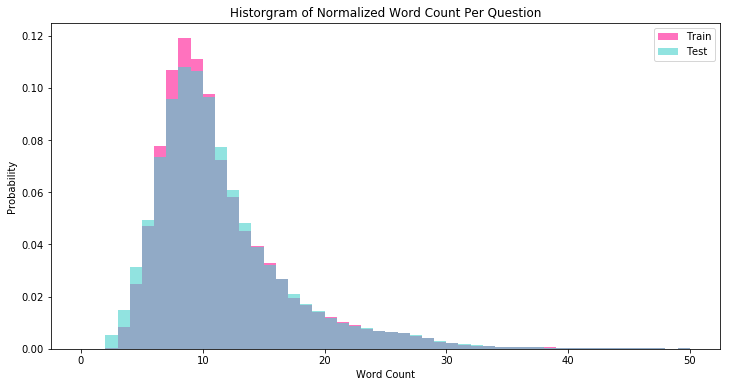

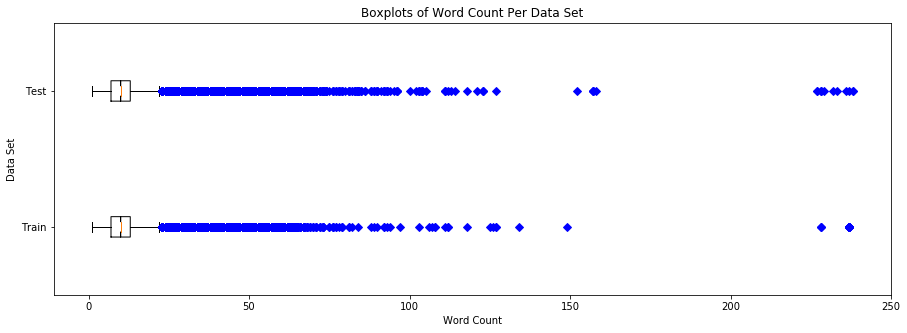

In [14]:
train_word_counts = pd.Series([len(str(x).split(' ')) for x in train_questions])
test_word_counts = pd.Series([len(str(x).split(' ')) for x in test_questions])

print('\nTrain Statistics')
print('----------------')
print(train_word_counts.describe())
print('\nTest Statistics')
print('---------------')
print(test_word_counts.describe())

plt.figure(figsize=(12,6))
plt.hist(train_word_counts, bins=50, range=[0, 50], color=('deeppink'), normed=True, alpha=0.6, label='Train')
plt.hist(test_word_counts, bins=50, range=[0, 50], color=('mediumturquoise'), normed=True, alpha=0.6, label='Test')
plt.xlabel('Word Count')
plt.ylabel('Probability')
plt.title('Historgram of Normalized Word Count Per Question')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.boxplot([train_word_counts, test_word_counts], True, 'bD', vert=False, labels=('Train', 'Test'))
plt.xlabel('Word Count')
plt.ylabel('Data Set')
plt.title('Boxplots of Word Count Per Data Set')
plt.show()

#### Character Count


TRAIN Statistics:
-----------------
count    808580.000000
mean         59.822548
std          31.963751
min           1.000000
25%          39.000000
50%          51.000000
75%          72.000000
max        1169.000000
dtype: float64

TEST Statistics:
----------------
count    4.691592e+06
mean     6.007010e+01
std      3.162463e+01
min      1.000000e+00
25%      4.000000e+01
50%      5.300000e+01
75%      7.200000e+01
max      1.176000e+03
dtype: float64


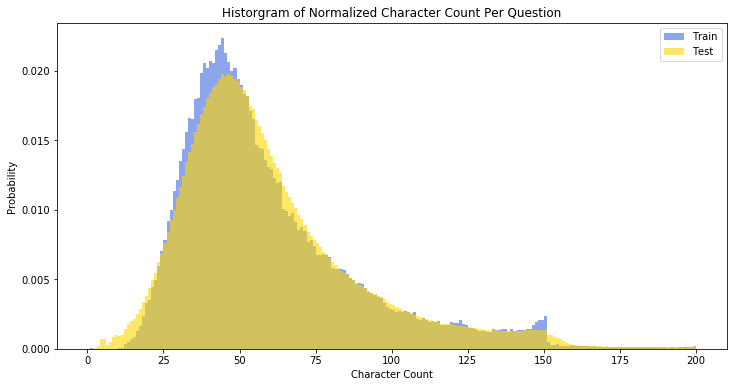

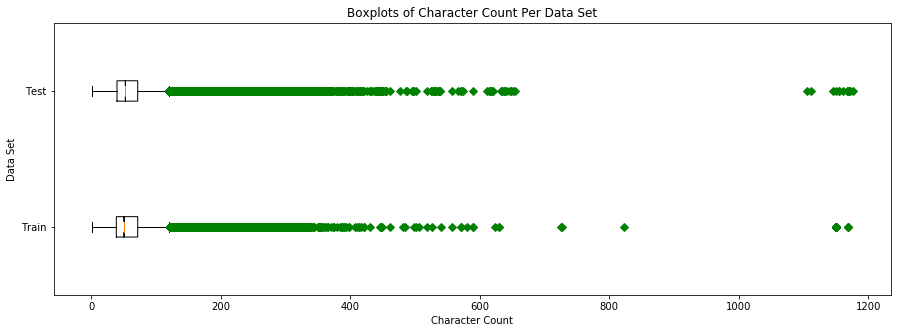

In [15]:
train_char_counts = pd.Series([len(str(x))for x in train_questions])
test_char_counts = pd.Series([len(str(x)) for x in test_questions])

print('\nTRAIN Statistics:')
print('-----------------')
print(train_char_counts.describe())
print('\nTEST Statistics:')
print('----------------')
print(test_char_counts.describe())

plt.figure(figsize=(12,6))
plt.hist(train_char_counts, bins=200, range=[0, 200], color=('royalblue'), normed=True, alpha=0.6, label='Train')
plt.hist(test_char_counts, bins=200, range=[0, 200], color=('gold'), normed=True, alpha=0.6, label='Test')
plt.xlabel('Character Count')
plt.ylabel('Probability')
plt.title('Historgram of Normalized Character Count Per Question')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.boxplot([train_char_counts, test_char_counts], True, 'gD', vert=False, labels=('Train', 'Test'))
plt.xlabel('Character Count')
plt.ylabel('Data Set')
plt.title('Boxplots of Character Count Per Data Set')
plt.show()

In [16]:
del train_questions, test_questions, train_word_counts, test_word_counts, train_char_counts, test_char_counts
gc.collect()

64528

### Feature Analysis

#### Text Preprocessing

In [39]:
# Tokenizing
tokenizer = RegexpTokenizer(r'\w+')

# Train
df = TRAIN.question1.append(TRAIN.question2).apply(lambda x: tokenizer.tokenize(str(x).lower()))
df.to_pickle('./pickles.gi/TRAIN_tokenized.pkl')

# Test
#df = TEST.question1.append(TEST.question2).apply(lambda x: tokenizer.tokenize(str(x).lower()))
#df.to_pickle('./pickles.gi/TEST_tokenized.pkl')

del tokenizer, df

In [40]:
# Stopword filtering
stopset = set(stopwords.words('english'))

# Train
df = pd.read_pickle('./pickles.gi/TRAIN_tokenized.pkl')
df = df.apply(lambda x: [w for w in x if w not in stopset])
df.to_pickle('./pickles.gi/TRAIN_filtered.pkl')

# Test
#df = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
#df = df.apply(lambda x: [w for w in x if w not in stopset])
#df.to_pickle('./pickles.gi/TEST_filtered.pkl')

del stopset, df

In [41]:
# Stemming (with and without stopword filtering)
stemmer = SnowballStemmer('english')

# Train - No filtering
df = pd.read_pickle('./pickles.gi/TRAIN_tokenized.pkl')
df = df.apply(lambda x: [stemmer.stem(w) for w in x])
df.to_pickle('./pickles.gi/TRAIN_stemmed.pkl')

# Train - Filtering
df = pd.read_pickle('./pickles.gi/TRAIN_filtered.pkl')
df = df.apply(lambda x: [stemmer.stem(w) for w in x])
df.to_pickle('./pickles.gi/TRAIN_stemmed_filtered.pkl')

# Test - No filtering
#df = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
#df = df.apply(lambda x: [stemmer.stem(w) for w in x])
#df.to_pickle('./pickles.gi/TEST_stemmed.pkl')

# Test - Filtering
#df = pd.read_pickle('./pickles.gi/TEST_filtered.pkl')
#df = df.apply(lambda x: [stemmer.stem(w) for w in x])
#df.to_pickle('./pickles.gi/TEST_stemmed_filtered.pkl')

del df, stemmer

In [42]:
# Lemmatizing (with and without stopword filtering)
lemmatizer = WordNetLemmatizer()

# Train - No filtering
df = pd.read_pickle('./pickles.gi/TRAIN_tokenized.pkl')
df = df.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.to_pickle('./pickles.gi/TRAIN_lemmatized.pkl')

# Train - Filtering
df = pd.read_pickle('./pickles.gi/TRAIN_filtered.pkl')
df = df.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.to_pickle('./pickles.gi/TRAIN_lemmatized_filtered.pkl')

# Test - No filtering
#df = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
#df = df.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
#df.to_pickle('./pickles.gi/TEST_lemmatized.pkl')

# Test - Filtering
#df = pd.read_pickle('./pickles.gi/TEST_filtered.pkl')
#df = df.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
#df.to_pickle('./pickles.gi/TEST_lemmatized_filtered.pkl')

del df, lemmatizer

In [19]:
# Combine preprocessed text into a stacked dataframe
df = pd.DataFrame()

# Train
df['pid'] = TRAIN.id.append(TRAIN.id)
df['qid'] = TRAIN.qid1.append(TRAIN.qid2)
df['base'] = pd.read_pickle('./pickles.gi/TRAIN_tokenized.pkl')
df['filtered'] = pd.read_pickle('./pickles.gi/TRAIN_filtered.pkl')
df['stemmed'] = pd.read_pickle('./pickles.gi/TRAIN_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TRAIN_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('./pickles.gi/TRAIN_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TRAIN_lemmatized_filtered.pkl')
df.reset_index(drop=True, inplace=True)
df.to_pickle('./pickles.gi/TRAIN_preprocessed_stacked.pkl')

# Test
#df['pid'] = TEST.test_id.append(TEST.test_id)
#df['qid'] = pd.Series(np.arange(len(TEST) * 2))
#df['base'] = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
#df['filtered'] = pd.read_pickle('./pickles.gi/TEST_filtered.pkl')
#df['stemmed'] = pd.read_pickle('./pickles.gi/TEST_stemmed.pkl')
#df['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TEST_stemmed_filtered.pkl')
#df['lemmatized'] = pd.read_pickle('./pickles.gi/TEST_lemmatized.pkl')
#df['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TEST_lemmatized_filtered.pkl')
#df.to_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')

del df

In [ ]:
# Create unstacked version of preprocessed dataframe

# Train
df = pd.read_pickle('./pickles.gi/TRAIN_preprocessed_stacked.pkl')
df = df.merge(df, how='inner', on='pid', suffixes=('_1','_2'))
df = df[(df['qid_1'] != df['qid_2']) & (df['qid_1'] < df['qid_2'])]
df.reset_index(drop=True, inplace=True)
df.to_pickle('./pickles.gi/TRAIN_preprocessed_unstacked.pkl')

# Test
#df = pd.read_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')
#df = df.merge(df, how='inner', on='pid', suffixes=('_1','_2'))
#df = df[(df['qid_1'] != df['qid_2']) & (df['qid_1'] < df['qid_1'])]
#df.reset_index(drop=True, inplace=True)
#df.to_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')

del df

In [93]:
# Tagging for Doc2Vec processing
df = pd.DataFrame()

# Train
preprocessed_stacked = pd.read_pickle('./pickles.gi/TRAIN_preprocessed_stacked.pkl')
df['pid'] = preprocessed_stacked.pid
df['qid'] = preprocessed_stacked.qid
df['base'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['base'], [x['qid']]), axis=1)
df['filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['filtered'], [x['qid']]), axis=1)
df['stemmed'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed'], [x['qid']]), axis=1)
df['stemmed_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed_filtered'], [x['qid']]), axis=1)
df['lemmatized'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized'], [x['qid']]), axis=1)
df['lemmatized_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized_filtered'], [x['qid']]), axis=1)
df.reset_index(drop=True, inplace=True)
df.to_pickle('./pickles.gi/TRAIN_tagged.pkl')

# Train
#preprocessed_stacked = pd.read_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')
#df['pid'] = preprocessed_stacked.pid
#df['qid'] = preprocessed_stacked.qid
#df['base'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['base'], [x['qid']]), axis=1)
#df['filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['filtered'], [x['qid']]), axis=1)
#df['stemmed'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed'], [x['qid']]), axis=1)
#df['stemmed_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed_filtered'], [x['qid']]), axis=1)
#df['lemmatized'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized'], [x['qid']]), axis=1)
#df['lemmatized_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized_filtered'], [x['qid']]), axis=1)
#df.reset_index(drop=True, inplace=True)
#df.to_pickle('./pickles.gi/TEST_tagged.pkl')

del df, preprocessed_stacked

#### Word Share

In [32]:
def calculate_word_share(q1, q2, tfidf_weights={}):
    if tfidf_weights:
        q1_shared = np.sum([tfidf_weights.get(x, 0) for x in q1 if x in q2])
        q2_shared = np.sum([tfidf_weights.get(x, 0) for x in q2 if x in q1])
        total = np.sum([tfidf_weights.get(x, 0) for x in q1]) + np.sum([tfidf_weights.get(x, 0) for x in q2])
    else:
        q1_shared = len([x for x in q1 if x in q2])
        q2_shared = len([x for x in q2 if x in q1])
        total = len(q1) + len(q2)
    if total == 0:
        return 0
    else:
        return (q1_shared + q2_shared) / total

In [42]:
TRAIN_preprocessed = pd.read_pickle('./pickles.gi/TRAIN_preprocessed_unstacked.pkl')

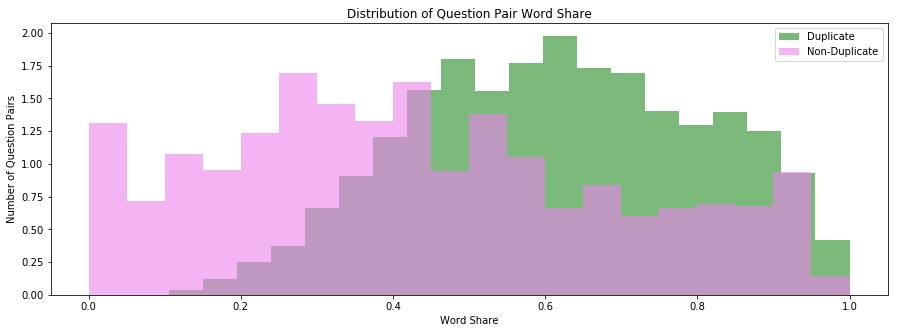

In [47]:
# Base
TRAIN_word_share_base = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['base_1'], x['base_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_base[TRAIN.is_duplicate == 1], bins=20, color=('forestgreen'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_base[TRAIN.is_duplicate == 0], bins=20, color=('violet'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share')
plt.legend()
plt.show()

TRAIN_word_share_base.to_pickle('./pickles.gi/TRAIN_word_share_base.pkl')

del TRAIN_word_share_base

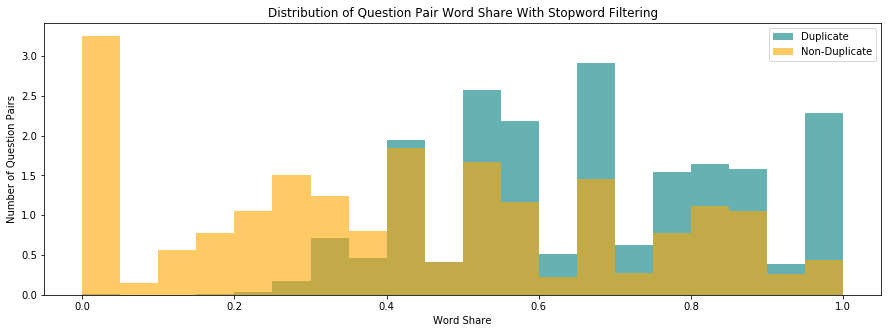

In [48]:
# Stopword filtering
TRAIN_word_share_filtered = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['filtered_1'], x['filtered_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_filtered[TRAIN.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_filtered[TRAIN.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share With Stopword Filtering')
plt.legend()
plt.show()

TRAIN_word_share_filtered.to_pickle('./pickles.gi/TRAIN_word_share_filtered.pkl')

del TRAIN_word_share_filtered

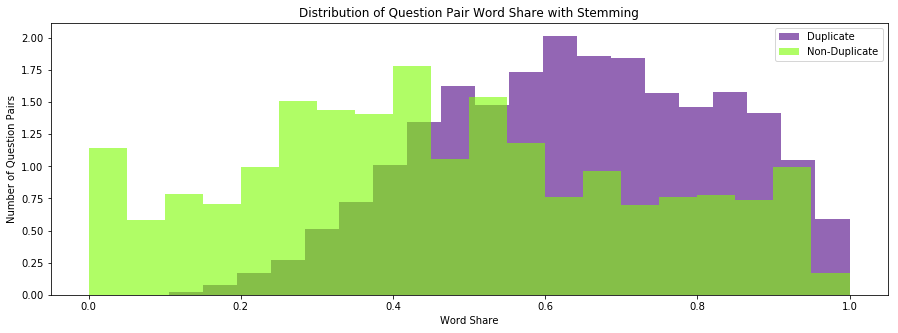

In [50]:
# Stemming
TRAIN_word_share_stemmed = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_1'], x['stemmed_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_stemmed[TRAIN.is_duplicate == 1], bins=20, color=('indigo'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_stemmed[TRAIN.is_duplicate == 0], bins=20, color=('lawngreen'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stemming')
plt.legend()
plt.show()

TRAIN_word_share_stemmed.to_pickle('./pickles.gi/TRAIN_word_share_stemmed.pkl')

del TRAIN_word_share_stemmed

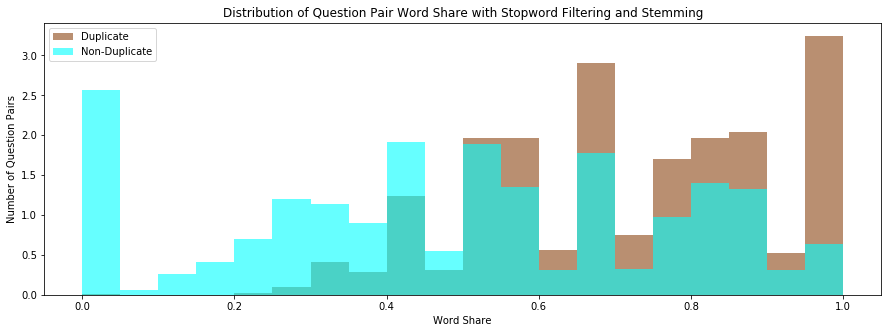

In [51]:
# Stopword filtering and stemming
TRAIN_word_share_stemmed_filtered = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_filtered_1'], x['stemmed_filtered_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_stemmed_filtered[TRAIN.is_duplicate == 1], bins=20, color=('saddlebrown'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_stemmed_filtered[TRAIN.is_duplicate == 0], bins=20, color=('cyan'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stopword Filtering and Stemming')
plt.legend()
plt.show()

TRAIN_word_share_stemmed_filtered.to_pickle('./pickles.gi/TRAIN_word_share_stemmed_filtered.pkl')

del TRAIN_word_share_stemmed_filtered

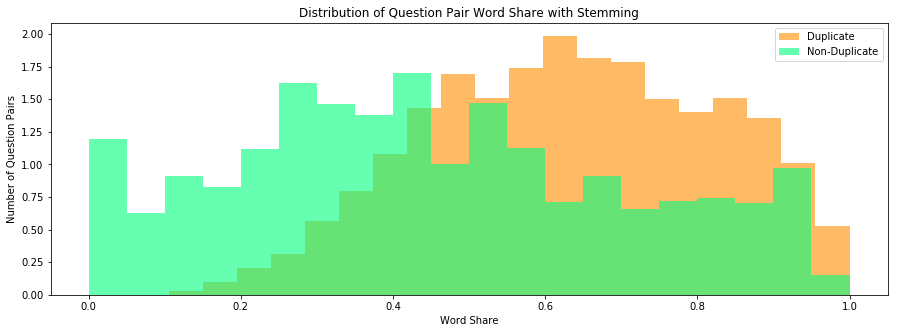

In [52]:
# Lemmatizing
TRAIN_word_share_lemmatized = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_1'], x['lemmatized_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_lemmatized[TRAIN.is_duplicate == 1], bins=20, color=('darkorange'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_lemmatized[TRAIN.is_duplicate == 0], bins=20, color=('springgreen'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stemming')
plt.legend()
plt.show()

TRAIN_word_share_lemmatized.to_pickle('./pickles.gi/TRAIN_word_share_lemmatized.pkl')

del TRAIN_word_share_lemmatized

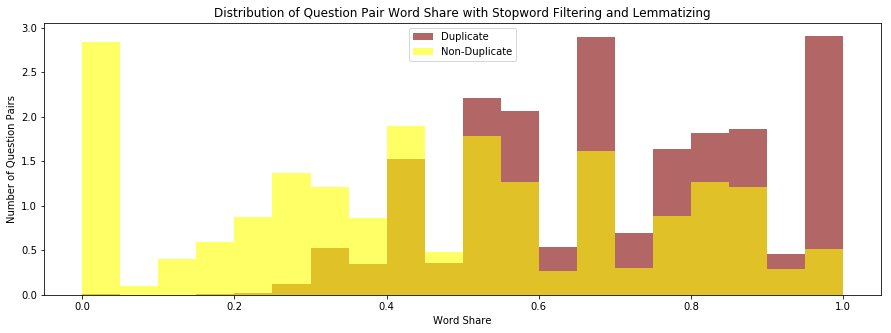

In [53]:
# Stopword filtering and lemmatizing
TRAIN_word_share_lemmatized_filtered = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_filtered_1'], x['lemmatized_filtered_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_lemmatized_filtered[TRAIN.is_duplicate == 1], bins=20, color=('maroon'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_lemmatized_filtered[TRAIN.is_duplicate == 0], bins=20, color=('yellow'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stopword Filtering and Lemmatizing')
plt.legend()
plt.show()

TRAIN_word_share_lemmatized_filtered.to_pickle('./pickles.gi/TRAIN_word_share_lemmatized_filtered.pkl')

del TRAIN_word_share_lemmatized_filtered

In [55]:
# Combine metrics into single dataframe
df = pd.DataFrame()
df['pid'] = TRAIN_preprocessed.pid
df['base'] = pd.read_pickle('./pickles.gi/TRAIN_word_share_base.pkl')
df['filtered'] = pd.read_pickle('./pickles.gi/TRAIN_word_share_filtered.pkl')
df['stemmed'] = pd.read_pickle('./pickles.gi/TRAIN_word_share_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TRAIN_word_share_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('./pickles.gi/TRAIN_word_share_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TRAIN_word_share_lemmatized_filtered.pkl')
df.to_pickle('./pickles.gi/TRAIN_word_share.pkl')

del df, TRAIN_preprocessed

#### TF-IDF

In [84]:
TRAIN_preprocessed_stacked = pd.read_pickle('./pickles.gi/TRAIN_preprocessed_stacked.pkl')
vectorizer = TfidfVectorizer()

# Base
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.base.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TRAIN_tfidf_weights_base.pkl', 'wb'))

# Filtered
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TRAIN_tfidf_weights_filtered.pkl', 'wb'))

# Stemmed
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.stemmed.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TRAIN_tfidf_weights_stemmed.pkl', 'wb'))

# Stemmed & Filtered
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.stemmed_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TRAIN_tfidf_weights_stemmed_filtered.pkl', 'wb'))

# Lemmatized
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.lemmatized.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TRAIN_tfidf_weights_lemmatized.pkl', 'wb'))

# Lemmatized & Filtered
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.lemmatized_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TRAIN_tfidf_weights_lemmatized_filtered.pkl', 'wb'))

del TRAIN_preprocessed_stacked, vectorizer, TDX, weights

In [75]:
TRAIN_preprocessed_unstacked = pd.read_pickle('./pickles.gi/TRAIN_preprocessed_unstacked.pkl')

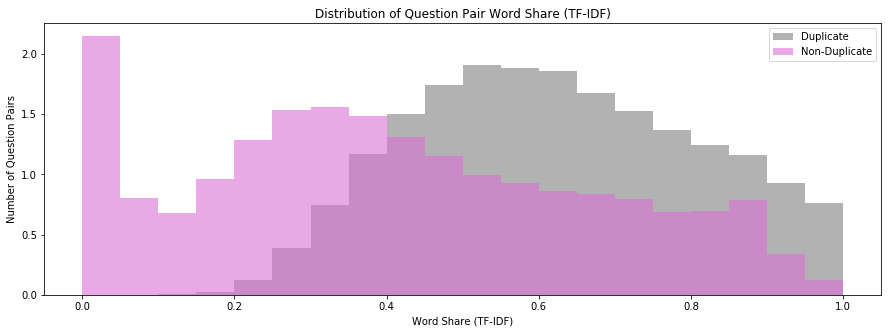

In [76]:
weights = pickle.load(open('./pickles.gi/TRAIN_tfidf_weights_base.pkl', 'rb'))
TRAIN_tfidf_word_share_base = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['base_1'], x['base_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_base[TRAIN.is_duplicate == 1], bins=20, color=('gray'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_base[TRAIN.is_duplicate == 0], bins=20, color=('orchid'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_base.to_pickle('./pickles.gi/TRAIN_tfidf_word_share_base.pkl')

del weights, TRAIN_tfidf_word_share_base

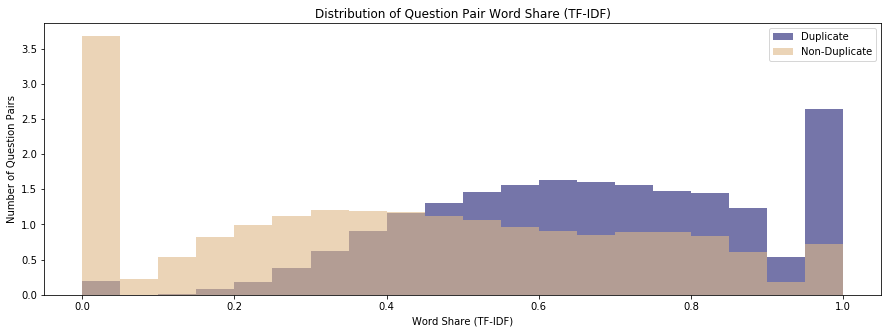

In [80]:
weights = pickle.load(open('./pickles.gi/TRAIN_tfidf_weights_filtered.pkl', 'rb'))
TRAIN_tfidf_word_share_filtered = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['filtered_1'], x['filtered_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_filtered[TRAIN.is_duplicate == 1], bins=20, color=('midnightblue'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_filtered[TRAIN.is_duplicate == 0], bins=20, color=('burlywood'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_filtered.to_pickle('./pickles.gi/TRAIN_tfidf_word_share_filtered.pkl')

del weights, TRAIN_tfidf_word_share_filtered

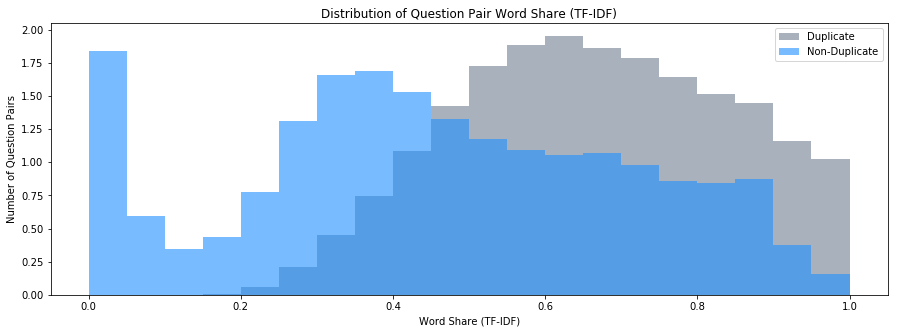

In [81]:
weights = pickle.load(open('./pickles.gi/TRAIN_tfidf_weights_stemmed.pkl', 'rb'))
TRAIN_tfidf_word_share_stemmed = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['stemmed_1'], x['stemmed_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_stemmed[TRAIN.is_duplicate == 1], bins=20, color=('slategray'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_stemmed[TRAIN.is_duplicate == 0], bins=20, color=('dodgerblue'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_stemmed.to_pickle('./pickles.gi/TRAIN_tfidf_word_share_stemmed.pkl')

del weights, TRAIN_tfidf_word_share_stemmed

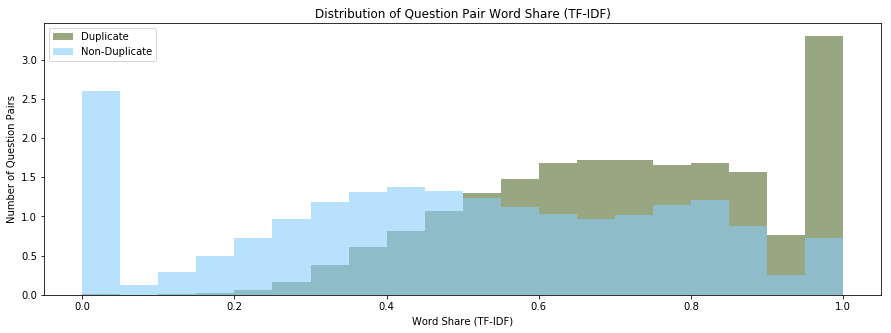

In [82]:
weights = pickle.load(open('./pickles.gi/TRAIN_tfidf_weights_stemmed_filtered.pkl', 'rb'))
TRAIN_tfidf_word_share_stemmed_filtered = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['stemmed_filtered_1'], x['stemmed_filtered_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_stemmed_filtered[TRAIN.is_duplicate == 1], bins=20, color=('darkolivegreen'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_stemmed_filtered[TRAIN.is_duplicate == 0], bins=20, color=('lightskyblue'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_stemmed_filtered.to_pickle('./pickles.gi/TRAIN_tfidf_word_share_stemmed_filtered.pkl')

del weights, TRAIN_tfidf_word_share_stemmed_filtered

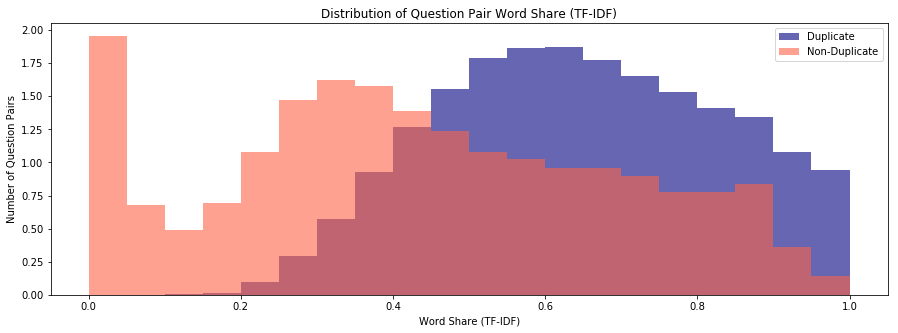

In [85]:
weights = pickle.load(open('./pickles.gi/TRAIN_tfidf_weights_lemmatized.pkl', 'rb'))
TRAIN_tfidf_word_share_lemmatized = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['lemmatized_1'], x['lemmatized_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_lemmatized[TRAIN.is_duplicate == 1], bins=20, color=('navy'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_lemmatized[TRAIN.is_duplicate == 0], bins=20, color=('tomato'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_lemmatized.to_pickle('./pickles.gi/TRAIN_tfidf_word_share_lemmatized.pkl')

del weights, TRAIN_tfidf_word_share_lemmatized

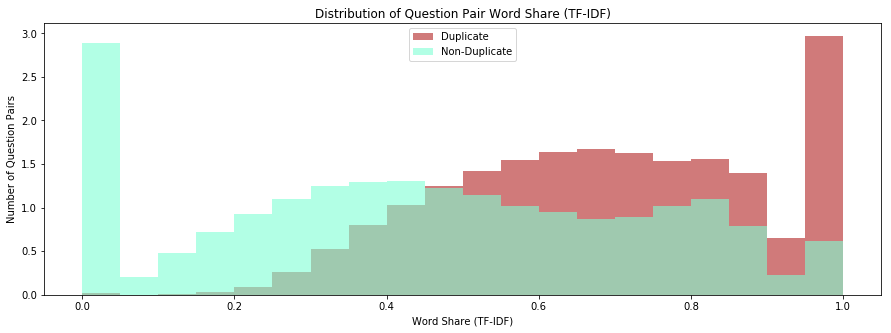

In [86]:
weights = pickle.load(open('./pickles.gi/TRAIN_tfidf_weights_lemmatized_filtered.pkl', 'rb'))
TRAIN_tfidf_word_share_lemmatized_filtered = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['lemmatized_filtered_1'], x['lemmatized_filtered_2'], weights), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_tfidf_word_share_lemmatized_filtered[TRAIN.is_duplicate == 1], bins=20, color=('firebrick'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_tfidf_word_share_lemmatized_filtered[TRAIN.is_duplicate == 0], bins=20, color=('aquamarine'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

TRAIN_tfidf_word_share_lemmatized_filtered.to_pickle('./pickles.gi/TRAIN_tfidf_word_share_lemmatized_filtered.pkl')

del weights, TRAIN_tfidf_word_share_lemmatized_filtered

In [87]:
# Combine metrics into single dataframe
df = pd.DataFrame()
df['pid'] = TRAIN_preprocessed_unstacked.pid
df['base'] = pd.read_pickle('./pickles.gi/TRAIN_tfidf_word_share_base.pkl')
df['filtered'] = pd.read_pickle('./pickles.gi/TRAIN_tfidf_word_share_filtered.pkl')
df['stemmed'] = pd.read_pickle('./pickles.gi/TRAIN_tfidf_word_share_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TRAIN_tfidf_word_share_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('./pickles.gi/TRAIN_tfidf_word_share_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TRAIN_tfidf_word_share_lemmatized_filtered.pkl')
df.to_pickle('./pickles.gi/TRAIN_tfidf_word_share.pkl')

del df, TRAIN_preprocessed_unstacked

#### ROC AUC Comparison

In [88]:
TRAIN_word_share = pd.read_pickle('./pickles.gi/TRAIN_word_share.pkl')
TRAIN_tfidf_word_share = pd.read_pickle('./pickles.gi/TRAIN_tfidf_word_share.pkl')

print('Word Share Proportion')
print('---------------------')
print('Base:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.base))
print('Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.filtered))
print('Stemmed:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.stemmed))
print('Stemmed & Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.stemmed_filtered))
print('Lemmatized:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.lemmatized))
print('Lemmatized & Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_word_share.lemmatized_filtered))
print('\nTF-IDF Weighting')
print('----------------')
print('Base:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.base))
print('Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.filtered))
print('Stemmed:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.stemmed))
print('Stemmed & Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.stemmed_filtered))
print('Lemmatized:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.lemmatized))
print('Lemmatized & Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, TRAIN_tfidf_word_share.lemmatized_filtered))

del TRAIN_word_share, TRAIN_tfidf_word_share

Word Share Proportion
---------------------
Base:                          0.717529896461
Filtered:                      0.743939809911
Stemmed:                       0.713523771993
Stemmed & Filtered:            0.737908827868
Lemmatized:                    0.716489894896
Lemmatized & Filtered:         0.743030404891

TF-IDF Weighting
----------------
Base:                          0.740072079517
Filtered:                      0.73889172313
Stemmed:                       0.735719806883
Stemmed & Filtered:            0.739308876228
Lemmatized:                    0.739323070552
Lemmatized & Filtered:         0.742681743386


#### Doc2Vec

In [22]:
# Multicore
cores = mp.cpu_count() - 1
assert d2v.FAST_VERSION > -1, "Doc2Vec will run painfully slow otherwise"

# Get doc list
tagged_docs = pd.read_pickle('./pickles.gi/TRAIN_tagged.pkl')
doc_list = tagged_docs.lemmatized_filtered.tolist()

# Build Model: PV-DM w/average
dmm_model = d2v.Doc2Vec(dm=1, dm_mean=1, size=300, window=5, negative=5, hs=0, min_count=2, workers=cores)

train_model = dmm_model

# Train model
alpha, min_alpha, passes = (0.025, 0.001, 10)
alpha_delta = (alpha - min_alpha) / passes

# Build vocab table
train_model.build_vocab(sentences=doc_list)

# Get pretrained word2vec weights where possible
train_model.intersect_word2vec_format('./word2vec.gi/GoogleNews-vectors-negative300.bin', binary=True)

print("START %s" % dt.datetime.now())

for epoch in range(passes):
    # shuffling gets best results
    shuffle(doc_list)

    print ('Training epoch %s' % epoch)

    # train
    train_model.alpha, train_model.min_alpha = alpha, alpha
    train_model.train(doc_list)

    print('completed pass %i at alpha %f' % (epoch + 1, alpha))
    print(str(dt.datetime.now()))
    
    alpha -= alpha_delta

train_model.save('./models.gi/dmm_model_lemmatized_filtered_word2vec_size300_iter10')

print("END %s" % str(dt.datetime.now()))

del cores, tagged_docs, dmm_model, doc_list, alpha, min_alpha, passes, alpha_delta, train_model

START 2017-05-10 19:28:13.491662
Training epoch 0
completed pass 1 at alpha 0.025000
2017-05-10 19:31:41.657485
Training epoch 1
completed pass 2 at alpha 0.022600
2017-05-10 19:35:08.918684
Training epoch 2
completed pass 3 at alpha 0.020200
2017-05-10 19:38:55.357011
Training epoch 3
completed pass 4 at alpha 0.017800
2017-05-10 19:42:14.659196
Training epoch 4
completed pass 5 at alpha 0.015400
2017-05-10 19:45:27.056608
Training epoch 5
completed pass 6 at alpha 0.013000
2017-05-10 19:49:02.592320
Training epoch 6
completed pass 7 at alpha 0.010600
2017-05-10 19:52:01.502830
Training epoch 7
completed pass 8 at alpha 0.008200
2017-05-10 19:55:36.078428
Training epoch 8
completed pass 9 at alpha 0.005800
2017-05-10 19:58:53.397738
Training epoch 9
completed pass 10 at alpha 0.003400
2017-05-10 20:02:00.884797
END 2017-05-10 20:02:02.222802


In [44]:
dmm_model = d2v.Doc2Vec.load('./models.gi/dmm_model_lemmatized_filtered_word2vec_size300_iter10')

TRAIN_preprocessed_unstacked = pd.read_pickle('./pickles.gi/TRAIN_preprocessed_unstacked.pkl')

df = pd.DataFrame()
df['vect_1'] = [dmm_model.infer_vector(x) for x in TRAIN_preprocessed_unstacked.lemmatized_filtered_1]
df['vect_2'] = [dmm_model.infer_vector(x) for x in TRAIN_preprocessed_unstacked.lemmatized_filtered_2]

TRAIN_d2v_cos_sim = pd.DataFrame()
TRAIN_d2v_cos_sim['lemmatized_filtered'] = df.apply(lambda x: 1 - cosine(x.vect_1, x.vect_2), axis=1)
TRAIN_d2v_cos_sim.to_pickle('./pickles.gi/TRAIN_d2v_cos_sim.pkl')

del dmm_model, TRAIN_preprocessed_unstacked, df, TRAIN_d2v_cos_sim

## TRAINING

### Train-Validate-Test  Split

In [45]:
TRAIN_word_share = pd.read_pickle('./pickles.gi/TRAIN_word_share.pkl')
TRAIN_tfidf_word_share = pd.read_pickle('./pickles.gi/TRAIN_tfidf_word_share.pkl')
TRAIN_d2v_cos_sim = pd.read_pickle('./pickles.gi/TRAIN_d2v_cos_sim.pkl')

X_train = pd.DataFrame()
X_train['word_share_base'] = TRAIN_word_share.base
X_train['word_share_filtered'] = TRAIN_word_share.filtered
X_train['word_share_stemmed'] = TRAIN_word_share.stemmed
X_train['word_share_stemmed_filtered'] = TRAIN_word_share.stemmed_filtered
X_train['word_share_lemmatized'] = TRAIN_word_share.lemmatized
X_train['word_share_lemmatized_filtered'] = TRAIN_word_share.lemmatized
X_train['tfidf_word_share_base'] = TRAIN_tfidf_word_share.base
X_train['tfidf_word_share_filtered'] = TRAIN_tfidf_word_share.filtered
X_train['tfidf_word_share_stemmed'] = TRAIN_tfidf_word_share.stemmed
X_train['tfidf_word_share_stemmed_filtered'] = TRAIN_tfidf_word_share.stemmed_filtered
X_train['tfidf_word_share_lemmatized'] = TRAIN_tfidf_word_share.lemmatized
X_train['tfidf_word_share_lemmatized_filtered'] = TRAIN_tfidf_word_share.lemmatized_filtered
X_train['d2v_cos_sim_lemmatized_filtered'] = TRAIN_d2v_cos_sim.lemmatized_filtered

#X_test = pd.DataFrame()
#X_test['word_share_base'] = TEST.apply(calculate_word_share, axis=1, raw=True)
#X_test['word_share_no_stopwords'] = test_word_share_no_stopwords
#X_test['word_share_stemmed'] = test_word_share_stemmed
#X_test['word_share_no_stopwords_stemmed'] = test_word_share_no_stopwords_stemmed
#X_test['word_share_tfidf'] = tfidf_test_word_share

y_train = TRAIN.is_duplicate.values

del TRAIN_word_share, TRAIN_tfidf_word_share, TRAIN_d2v_cos_sim

In [91]:
del df

### Minority Class Over-Sampling

In [48]:
# https://github.com/scikit-learn-contrib/imbalanced-learn
# https://beckernick.github.io/oversampling-modeling/

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
print('Number of added samples: ', str(X_train_smote.shape[0] - X_train.shape[0]))

Number of added samples:  105764


### Validation Set

In [49]:
# Validation Set
X_training, X_validation, y_training, y_validation = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=42)

### XGBoost

#### Initial Training with Grid Search and Cross Validation

In [79]:
cores = mp.cpu_count() - 1

params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,10,2)
}

xgb_model = xgb.XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=27)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='neg_log_loss', cv=4, verbose=10)

grid_search.fit(X_training, y_training)

grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] . max_depth=3, min_child_weight=1, score=-0.463556, total= 1.3min
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=1, score=-0.460754, total= 1.3min
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=1, score=-0.460443, total= 1.3min
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=1, score=-0.458892, total= 1.3min
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.3min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=3, score=-0.463522, total= 1.3min
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=3, score=-0.460502, total= 1.3min
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.9min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=3, score=-0.460091, total= 1.3min
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.3min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=3, score=-0.459325, total= 1.3min
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 10.5min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=5, score=-0.463901, total= 1.3min
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 11.9min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=5, score=-0.460330, total= 1.3min
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.460492, total= 1.3min
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.459002, total= 1.3min
[CV] max_depth=3, min_child_weight=7 .................................
[CV] . max_depth=3, min_child_weight=7, score=-0.463878, total= 1.3min
[CV] max_depth=3, min_child_weight=7 .................................
[CV] . max_depth=3, min_child_weight=7, score=-0.460947, total= 1.3min
[CV] max_depth=3, min_child_weight=7 .................................
[CV] . max_depth=3, min_child_weight=7, score=-0.460133, total= 1.3min
[CV] max_depth=3, min_child_weight=7 .................................
[CV] . max_depth=3, min_child_weight=7, score=-0.459067, total= 1.3min
[CV] max_depth=3, min_child_weight=9 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 206.0min finished
C:\Users\camro\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.46091, std: 0.00168, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.46086, std: 0.00159, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.46093, std: 0.00181, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.46101, std: 0.00179, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: -0.46099, std: 0.00164, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: -0.43994, std: 0.00197, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.43983, std: 0.00172, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.43968, std: 0.00165, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.43989, std: 0.00230, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: -0.44035, std: 0.00183, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: -0.42894, std: 0.00163, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.42888, std: 0.00151, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.42984, std: 0.001

A max_depth=9 and a min_child_weight=1 performed the best at a 0.42318143814217912 log loss, which unfortunately, is still not a very good score.

#### Feature Importance & Pruning

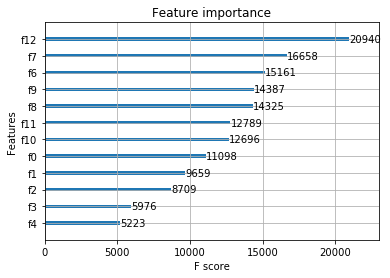

In [81]:
xgb.plot_importance(grid_search.best_estimator_)

Features 3 (word_share_stemmed_filtered) and 4 (word_share_lemmatized) were identified as least important.  Could this be because the lemmatized_filtered token list was used to train Doc2Vec, and therefore, are highly colinear?

In [87]:
X_training_pruned = pd.DataFrame(X_training).drop(pd.DataFrame(X_training).columns[[3, 4]], axis=1)
X_validation_pruned = pd.DataFrame(X_validation).drop(pd.DataFrame(X_validation).columns[[3, 4]], axis=1)

#### GPU Training

In [88]:
gpu_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.01,
    'max_depth': 9,
    'min_child_weight': 1,
    'updater': 'grow_gpu',
    'n_estimators': 1000,
    'scale_pos_weight': 1
}

D_training = xgb.DMatrix(X_training_pruned, label=y_training)
D_validation = xgb.DMatrix(X_validation_pruned, label=y_validation)
watchlist = [(D_training, 'training'), (D_validation, 'validation')]

bst = xgb.train(gpu_params, D_training, 50000, watchlist, early_stopping_rounds=10000, verbose_eval=50)

[0]	training-logloss:0.792638	validation-logloss:0.790627
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 10000 rounds.
[50]	training-logloss:0.632802	validation-logloss:0.639164
[100]	training-logloss:0.57865	validation-logloss:0.587273
[150]	training-logloss:0.554303	validation-logloss:0.564753
[200]	training-logloss:0.541251	validation-logloss:0.552906
[250]	training-logloss:0.535135	validation-logloss:0.547597
[300]	training-logloss:0.528552	validation-logloss:0.542395
[350]	training-logloss:0.524566	validation-logloss:0.539959
[400]	training-logloss:0.521451	validation-logloss:0.537629
[450]	training-logloss:0.546862	validation-logloss:0.564089
[500]	training-logloss:0.519946	validation-logloss:0.539806
[550]	training-logloss:0.509957	validation-logloss:0.531529
[600]	training-logloss:0.527174	validation-logloss:0.550245
[650]	training-logloss:0.506143	validation-logloss:0.530967


#### Test Set Prep & Predictions

In [ ]:
# Combine preprocessed text into a stacked dataframe
df['pid'] = TEST.test_id.append(TEST.test_id)
df['qid'] = pd.Series(np.arange(len(TEST) * 2))
df['base'] = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
df['filtered'] = pd.read_pickle('./pickles.gi/TEST_filtered.pkl')
df['stemmed'] = pd.read_pickle('./pickles.gi/TEST_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TEST_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('./pickles.gi/TEST_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TEST_lemmatized_filtered.pkl')
df.to_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')

# Create unstacked version of preprocessed dataframe
df = pd.read_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')
df = df.merge(df, how='inner', on='pid', suffixes=('_1','_2'))
df = df[(df['qid_1'] != df['qid_2']) & (df['qid_1'] < df['qid_1'])]
df.reset_index(drop=True, inplace=True)
df.to_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')

# Tagging for Doc2Vec processing
preprocessed_stacked = pd.read_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')
df = pd.DataFrame()
df['pid'] = preprocessed_stacked.pid
df['qid'] = preprocessed_stacked.qid
df['base'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['base'], [x['qid']]), axis=1)
df['filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['filtered'], [x['qid']]), axis=1)
df['stemmed'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed'], [x['qid']]), axis=1)
df['stemmed_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed_filtered'], [x['qid']]), axis=1)
df['lemmatized'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized'], [x['qid']]), axis=1)
df['lemmatized_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized_filtered'], [x['qid']]), axis=1)
df.reset_index(drop=True, inplace=True)
df.to_pickle('./pickles.gi/TEST_tagged.pkl')

In [ ]:
# Word share
TEST_word_share_base = TEST_preprocessed.apply(lambda x: calculate_word_share(x['base_1'], x['base_2']), axis=1, raw=True)
TEST_word_share_filtered = TEST_preprocessed.apply(lambda x: calculate_word_share(x['filtered_1'], x['filtered_2']), axis=1, raw=True)
TEST_word_share_stemmed = TEST_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_1'], x['stemmed_2']), axis=1, raw=True)
TEST_word_share_stemmed_filtered = TEST_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_filtered_1'], x['stemmed_filtered_2']), axis=1, raw=True)
TEST_word_share_lemmatized = TEST_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_1'], x['lemmatized_2']), axis=1, raw=True)
TEST_word_share_lemmatized_filtered = TEST_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_filtered_1'], x['lemmatized_filtered_2']), axis=1, raw=True)

# Combine word share metrics into single dataframe
df = pd.DataFrame()
df['pid'] = TEST_preprocessed.pid
df['base'] = pd.read_pickle('./pickles.gi/TEST_word_share_base.pkl')
df['filtered'] = pd.read_pickle('./pickles.gi/TEST_word_share_filtered.pkl')
df['stemmed'] = pd.read_pickle('./pickles.gi/TEST_word_share_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TEST_word_share_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('./pickles.gi/TEST_word_share_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TEST_word_share_lemmatized_filtered.pkl')
df.to_pickle('./pickles.gi/TEST_word_share.pkl')

In [ ]:
# TF-IDF
TEST_preprocessed_stacked = pd.read_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')
vectorizer = TfidfVectorizer()

# Base
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.base.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_base.pkl', 'wb'))

# Filtered
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_filtered.pkl', 'wb'))

# Stemmed
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.stemmed.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_stemmed.pkl', 'wb'))

# Stemmed & Filtered
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.stemmed_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_stemmed_filtered.pkl', 'wb'))

# Lemmatized
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.lemmatized.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_lemmatized.pkl', 'wb'))

# Lemmatized & Filtered
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.lemmatized_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_lemmatized_filtered.pkl', 'wb'))

In [ ]:
#Doc2Vec
dmm_model = d2v.Doc2Vec.load('./models.gi/dmm_model_lemmatized_filtered_word2vec_size300_iter10')
TEST_preprocessed_unstacked = pd.read_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')

df = pd.DataFrame()
df['vect_1'] = [dmm_model.infer_vector(x) for x in TEST_preprocessed_unstacked.lemmatized_filtered_1]
df['vect_2'] = [dmm_model.infer_vector(x) for x in TEST_preprocessed_unstacked.lemmatized_filtered_2]

TEST_d2v_cos_sim = pd.DataFrame()
TEST_d2v_cos_sim['lemmatized_filtered'] = df.apply(lambda x: 1 - cosine(x.vect_1, x.vect_2), axis=1)
TEST_d2v_cos_sim.to_pickle('./pickles.gi/TEST_d2v_cos_sim.pkl')

In [ ]:
# Train Test Split
X_test = pd.DataFrame()
X_test['word_share_base'] = TRAIN_word_share.base
X_test['word_share_filtered'] = TRAIN_word_share.filtered
X_test['word_share_stemmed'] = TRAIN_word_share.stemmed
X_test['word_share_stemmed_filtered'] = TRAIN_word_share.stemmed_filtered
X_test['word_share_lemmatized'] = TRAIN_word_share.lemmatized
X_test['word_share_lemmatized_filtered'] = TRAIN_word_share.lemmatized
X_test['tfidf_word_share_base'] = TRAIN_tfidf_word_share.base
X_test['tfidf_word_share_filtered'] = TRAIN_tfidf_word_share.filtered
X_test['tfidf_word_share_stemmed'] = TRAIN_tfidf_word_share.stemmed
X_test['tfidf_word_share_stemmed_filtered'] = TRAIN_tfidf_word_share.stemmed_filtered
X_test['tfidf_word_share_lemmatized'] = TRAIN_tfidf_word_share.lemmatized
X_test['tfidf_word_share_lemmatized_filtered'] = TRAIN_tfidf_word_share.lemmatized_filtered
X_test['d2v_cos_sim_lemmatized_filtered'] = TRAIN_d2v_cos_sim.lemmatized_filtered

# Predict
d_test = xgb.DMatrix(pd.DataFrame(X_test).drop(pd.DataFrame(X_test).columns[[3, 4]], axis=1))
p_test = bst.predict(d_test)

# Submission File
sub = pd.DataFrame()
sub['test_id'] = TEST['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('./submission_final.csv', index=False)